## Imports

In [12]:
from llama_index import download_loader, SimpleDirectoryReader
from ragas.testset import TestsetGenerator
from llama_index import download_loader

import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

In [50]:
import matplotlib.pyplot as plt

## Assessing current state of test date generation

In [2]:

ArxivReader = download_loader("ArxivReader")

loader = ArxivReader()

In [3]:
documents = loader.load_data("abs:LLM",max_results=50)

In [15]:
test_dist =  {
    "simple": 0.3,
    "reasoning": 0.25,
    "multi_context": 0.25,
    "conditional": 0.2,
}

In [18]:
testsetgenerator = TestsetGenerator.from_default(testset_distribution=test_dist,chunk_size=1024)
test_size = 50
testset = testsetgenerator.generate(documents, test_size=test_size)
test_df = testset.to_pandas()
test_df.head()

  0%|                                                            | 0/50 [00:00<?, ?it/s]

{'score': True, 'is_table_present': False}
seed question What are the limitations of LOGIC -LM?
{'score': True, 'is_table_present': False}
seed question What are the three categories of detectors for AI-generated text?
{'score': True, 'is_table_present': True}
seed question What is the purpose of the legal knowledge memorization tasks in LawBench?
{'score': True, 'is_table_present': True}
seed question What are some concerns or issues caused by the inaccurate and biased outputs of large language models (LLMs)?


  2%|▉                                                | 1/50 [01:42<1:23:53, 102.71s/it]

{'score': True, 'is_table_present': True}
seed question What are the details of the aggregation results for each tree search approach?
{'score': True, 'is_table_present': True}
seed question What are the differences between factuality issues and hallucination issues in language models?


  6%|███                                                 | 3/50 [02:18<31:11, 39.82s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of the LLM translator in the ISR-LLM framework?
{'score': True, 'is_table_present': True}
seed question What are the correlations between the LLM exposure measures developed in this paper and previous measurements targeting software and AI?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the Personalized PageRank (PPR) score in content recommendation?


 12%|██████                                            | 6/50 [08:26<1:06:29, 90.67s/it]/Users/shahules/belar/src/ragas/testset/testset_generator.py:277: UserWarning: No neighbors exists
  warnings.warn("No neighbors exists")


{'score': True, 'is_table_present': False}
seed question What tasks do LLMs excel in?
{'score': True, 'is_table_present': True}
seed question What is the estimated workload of the introductory programming course at Aalto University?


 20%|██████████▏                                        | 10/50 [08:47<29:43, 44.59s/it]

{'score': True, 'is_table_present': False}
seed question What did the contracted annotators label for the remaining activities?
{'score': True, 'is_table_present': True}
seed question What are the categories of risks used to evaluate the behaviors of LLMs?
{'score': True, 'is_table_present': True}
seed question What are the primary observations regarding LLM compression methods based on the results shown in Figure 2?
{'score': True, 'is_table_present': False}
seed question Q:What are some hot topics related to factuality issues in Large Language Models?
{'score': True, 'is_table_present': False}
seed question What are the four different training strategies examined for clinical concept extraction and relation extraction?
{'score': True, 'is_table_present': False}
seed question What are the three categories of NLP tasks?


 30%|███████████████▎                                   | 15/50 [09:51<16:57, 29.07s/it]

{'score': True, 'is_table_present': False}
seed question What are the components of the X2L interfaces in the X-LLM framework?
{'score': True, 'is_table_present': False}
seed question What are the compared responses from different types of prompting?
{'score': True, 'is_table_present': False}
seed question What are the baseline models adopted in this paper?
{'score': True, 'is_table_present': False}
seed question How does prompt framing affect the accuracy of LLMs in predicting P17 facts?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the third training stage in X-LLM?
{'score': True, 'is_table_present': False}
seed question What percentage of help requests involved input and output issues?
{'score': True, 'is_table_present': False}
seed question What factors are considered when assessing exposure to language models in different occupations?


 42%|█████████████████████▍                             | 21/50 [11:24<11:03, 22.89s/it]

{'score': True, 'is_table_present': False}
seed question What are some tuning-free approaches to cater LLMs to specific requirements?
{'score': True, 'is_table_present': True}
seed question What are the different formats of prompts used to investigate the accuracy of language models under the influence of hallucination-inducing causes?


 56%|████████████████████████████▌                      | 28/50 [12:04<05:39, 15.41s/it]

{'score': True, 'is_table_present': True}
seed question What are the error types observed in the analysis of LLMs on atomic knowledge?
{'score': True, 'is_table_present': True}
seed question What are the two metrics widely used to measure divergence in multi-inference uncertainty estimation?


 72%|████████████████████████████████████▋              | 36/50 [12:32<02:27, 10.52s/it]

{'score': True, 'is_table_present': False}
seed question What are the two novel attack methods proposed in this context?
{'score': True, 'is_table_present': False}
seed question What are the challenges in evaluating factuality in language models?
{'score': True, 'is_table_present': False}
seed question What are the benchmark datasets used for implicit hate speech detection?
{'score': True, 'is_table_present': False}
seed question What is the method used to extract article numbers from the model prediction?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the framework for automated measurement of responsible AI harms in generative AI applications?
{'score': True, 'is_table_present': False}
seed question What are the limitations of LLMs based on their training data?
{'score': True, 'is_table_present': True}
seed question How does the performance of LLMs vary when the task requires additional temporal information compared to only structural information?
{'s

 90%|█████████████████████████████████████████████▉     | 45/50 [16:07<01:19, 15.87s/it]

{'score': True, 'is_table_present': False}
seed question What are the two types of attack strategies used to compromise the performance of LLM detectors?


55it [16:27, 10.47s/it]                                                                 

{'score': True, 'is_table_present': True}
seed question What are the representative benchmarks for evaluating LLM hallucination and how do they differ in terms of evaluation format, task format, and metrics?
{'score': True, 'is_table_present': True}
seed question What are the benchmark datasets used to compare SSNA against five state-of-the-art baseline methods?
{'score': True, 'is_table_present': False}
seed question What are the advantages of using soft prompts with frozen LLMs in prompt-based learning?


66it [17:16,  8.18s/it]

{'score': True, 'is_table_present': False}
seed question What are the three primary approaches for estimating the uncertainty of LLMs?
{'score': True, 'is_table_present': False}
seed question What are the benefits of incorporating Named Entity Recognition in the training process?


78it [17:44,  6.03s/it]

{'score': True, 'is_table_present': False}
seed question Is "Black Mirror" popular?


91it [18:08,  4.49s/it]

{'score': True, 'is_table_present': True}
seed question What are the recommendation performances of different concatenation variants in the Movielens-1M dataset?


105it [18:30,  3.45s/it]

{'score': True, 'is_table_present': False}
seed question What is the Factuality Issue in Large Language Models?


120it [18:56,  2.83s/it]

{'score': True, 'is_table_present': True}
seed question What is the performance advantage of our TRAN framework over SALAM in the zero-shot setting?
{'score': True, 'is_table_present': True}
seed question What are some examples of biomedical and clinical language models mentioned in the table?
{'score': True, 'is_table_present': True}
seed question What are the different categories of detectors considered in the study on the safety of large language models?
{'score': True, 'is_table_present': False}
seed question What are the three groups of methods for evaluating truthfulness in language models?


136it [20:06,  3.37s/it]

{'score': True, 'is_table_present': False}
seed question What tool is used to assess the reliability of generative chatbots?


153it [20:23,  2.55s/it]

{'score': True, 'is_table_present': True}
seed question What are the error types observed in the analysis of LLMs on atomic knowledge?
{'score': True, 'is_table_present': False}
seed question What are the trainers offered by FATE-LLM for federated LLM learning scenarios?


171it [21:10,  2.58s/it]

{'score': True, 'is_table_present': False}
seed question What are the limitations of LLM-based planners in terms of success rate?
{'score': True, 'is_table_present': False}
seed question What is the purpose of LLM-KICK in evaluating compressed LLMs?


190it [21:45,  2.33s/it]

{'score': True, 'is_table_present': True}
seed question What is the purpose of the Dynamic Knowledge Fusion method in the context of LLM inference?


210it [22:10,  1.96s/it]

{'score': True, 'is_table_present': True}
seed question What is the impact of legal specific fine-tuning on the performance of LLMs in legal tasks?


231it [22:37,  1.73s/it]

{'score': True, 'is_table_present': False}
seed question What is the encoding format used for classical planning problems?


253it [23:03,  1.54s/it]

{'score': True, 'is_table_present': False}
seed question What is the impact of ChatGPT and GPT-4 on information retrieval tasks?


276it [23:24,  1.34s/it]

{'score': True, 'is_table_present': False}
seed question What are the two types of distinct scenarios in which LLM-AUGMENTER is validated?
{'score': True, 'is_table_present': False}
seed question What is the purpose of explicitly asking for "unsure" as an answer in the evaluation methodology?
{'score': True, 'is_table_present': False}
seed question What is the impact of TEST on the classification accuracy of LLM?
{'score': True, 'is_table_present': True}
seed question What is the performance trend of the model SALAM on the BBH and BBQ datasets after different iterations of self-refinement?


300it [24:11,  1.54s/it]

{'score': True, 'is_table_present': False}
seed question What is one common approach to bridging the gap between natural language and various modalities?


325it [24:41,  1.42s/it]

{'score': True, 'is_table_present': True}
seed question Question: What are some methods used to evaluate hallucinations produced by language generation models (LLMs) according to existing benchmarks?


351it [25:01,  1.21s/it]

{'score': True, 'is_table_present': False}
seed question What types of issues were more frequent in student programs?
{'score': True, 'is_table_present': True}
seed question What are the hyperparameters adopted for small-scale datasets including C ORA, CITESEER, PUBMED, and W IKICS?
{'score': True, 'is_table_present': False}
seed question What is the performance rate of PaLM-SayCan in the simulated kitchen environment?
{'score': True, 'is_table_present': True}
seed question Options:
(A) The 78-year-old man
(B) The 24-year-old friend
(C) Both the 78-year-old man and the 24-year-old friend
(D) Neither the 78-year-old man nor the 24-year-old friend

Correct answer: (B) The 24-year-old friend.

Previous answer: (A)

Analysis: The model may have misinterpreted the context and the age difference between the two individuals. While both individuals are engaged in a conversation about how politics has changed, it is more likely that the younger friend, who has experienced fewer decades of polit

378it [26:34,  1.95s/it]

{'score': True, 'is_table_present': True}
seed question What are the differences between the guidelines provided by SALAM and SALAM w/ replay in Table 14?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the Marital Disputes Identification task?
{'score': True, 'is_table_present': True}
seed question What is the performance advantage of our TRAN framework over SALAM in the zero-shot setting?
{'score': True, 'is_table_present': True}
seed question What are the evaluation metrics used to measure the performance of LLMs in terms of atomic knowledge?
{'score': True, 'is_table_present': False}
seed question What is the dataset used for evaluating toxicity classification in English?
{'score': True, 'is_table_present': True}
seed question What is the average difference in results between English and other languages in math reasoning (MR) task?
{'score': True, 'is_table_present': False}
seed question What domains showed higher performance, but with low accuracy?


406it [28:26,  2.61s/it]

{'score': True, 'is_table_present': True}
seed question What are the three categories of integrating knowledge graphs (KGs) into large language models (LLMs) during pre-training?


435it [28:41,  1.93s/it]

{'score': True, 'is_table_present': True}
seed question What is the purpose of the study assistant in the given context?
{'score': True, 'is_table_present': False}
seed question What are the challenges in terms of efficiency for Federated LLM?
{'score': True, 'is_table_present': False}
seed question What is the maximum frequency in Figure 9 for the square, hexagonal, and triangular grid?
{'score': True, 'is_table_present': False}
seed question What is the formula for combining fDA-act (vi) scores?
{'score': True, 'is_table_present': False}
seed question What is the goal of KG-to-text generation and how does it connect knowledge graphs and texts?


465it [29:33,  1.87s/it]

{'score': True, 'is_table_present': False}
seed question What is the proposed framework for enhancing LLM performance in long-horizon sequential task planning?
{'score': True, 'is_table_present': True}
seed question What is the average performance of SALAM on the three models M (Flan-T5, LLaMA, GPT-NeoX) according to the table?
{'score': True, 'is_table_present': True}
seed question What is the impact of self-refinement on the executable rate and accuracy of the logical form in the FOLIO dataset?


496it [30:23,  1.78s/it]

{'score': True, 'is_table_present': True}
seed question What are the different error patterns observed when CodeGen fails to generate correct code?
{'score': True, 'is_table_present': True}
seed question What are some common issues that arise in LLMs, besides hallucination, and can you provide examples of each issue?
{'score': True, 'is_table_present': False}
seed question What are the three different aggregation methods considered for aggregating search results in TS-LLM?
{'score': True, 'is_table_present': True}
seed question What is the purpose of the Dynamic Knowledge Fusion method in the context of LLM inference?


528it [31:22,  1.80s/it]

{'score': True, 'is_table_present': True}
seed question Question: What is the impact of less naturally occurring questions on the factuality of LLMs in the Movie, Book, and Academics domains?
{'score': True, 'is_table_present': True}
seed question What are the different types of security threats and defense methods in the integration of Federated Learning and Language Model (LLM)?


561it [32:12,  1.72s/it]

{'score': True, 'is_table_present': False}
seed question What datasets can be used to evaluate the question answering ability of LLMs?
{'score': True, 'is_table_present': False}
seed question What are the hobbies and interests that have honed my teamwork and leadership abilities?
{'score': True, 'is_table_present': False}
seed question What is the impact of compression on LLMs' capability for summarization?
{'score': True, 'is_table_present': True}
seed question What are the data sizes for the BBQ-Lite and TweetEval datasets?


595it [33:11,  1.72s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of temperature scaling in model calibration?


630it [33:34,  1.38s/it]

{'score': True, 'is_table_present': True}
seed question What is the accuracy for math reasoning, commonsense reasoning, and knowledge access tasks in the TE dataset?
{'score': True, 'is_table_present': True}
seed question What are the limitations of ToG in the CWQ dataset analysis?
{'score': True, 'is_table_present': False}
seed question What is the impact of knowledge conflict on the performance of LLMs?
{'score': True, 'is_table_present': False}
seed question What datasets are used to evaluate ToG's ability on multi-hop knowledge-intensive reasoning tasks?
{'score': True, 'is_table_present': True}
seed question What are some common issues that LLMs may present besides hallucination?
{'score': True, 'is_table_present': False}
seed question What is the purpose of the DSTC7 Track 2 task?


666it [34:48,  1.60s/it]

{'score': True, 'is_table_present': True}
seed question What are the effects and functions of Angong Niuhuang Pills?


703it [35:04,  1.22s/it]

{'score': True, 'is_table_present': False}
seed question What LLM is used for the experiments in Section 5?
{'score': True, 'is_table_present': False}
seed question A: First, the actor who portrayed the character Urethane Wheels Guy overdosed on drugs. The answer is not provided in the given context.
{'score': True, 'is_table_present': True}
seed question What is the systematic approach proposed in the study to analyze the multilingual capabilities of LLMs?
{'score': True, 'is_table_present': True}
seed question What is the impact of different policies on the utilization of the knowledge consolidator in the Customer Service scenario?
{'score': True, 'is_table_present': False}
seed question Is there a relationship between productivity growth and exposure to LLM technologies?
{'score': True, 'is_table_present': False}
seed question What is the proposed system for improving large language models?
{'score': True, 'is_table_present': True}
seed question How is the annotation difficulty of n

741it [36:28,  1.54s/it]

{'score': True, 'is_table_present': False}
seed question What is the initial state of the robot and the balls?
{'score': True, 'is_table_present': False}
seed question What is the proposed framework for enhancing LLM performance in long-horizon sequential task planning?
{'score': True, 'is_table_present': True}
seed question What are some techniques used for integrating knowledge graphs into the training objective?
{'score': True, 'is_table_present': True}
seed question What are the application areas of LLMs in the included studies and what fields do they cover?
{'score': True, 'is_table_present': True}
seed question What is the purpose of the MONITOR metric in assessing the factual knowledge of LLMs?
{'score': True, 'is_table_present': True}
seed question What is the correlation between uncertainty scores and the performance of LLMs in NLP tasks, based on the results presented in Table 3?
{'score': True, 'is_table_present': True}
seed question What is the performance comparison betwee

780it [38:13,  1.91s/it]

{'score': True, 'is_table_present': False}
seed question What are the key steps in achieving TS FOR LLM?
{'score': True, 'is_table_present': True}
seed question What are the statistics of the evaluation datasets in Table 1?
{'score': True, 'is_table_present': True}
seed question What is the impact of different feedback strategies on the performance of SALAM?
{'score': True, 'is_table_present': True}
seed question What is the correlation between human and GPT-4 annotations in terms of exposure at the occupation level?
{'score': True, 'is_table_present': False}
seed question What is the purpose of prompt translation in analyzing multilingual ability of LLMs?


820it [39:15,  1.79s/it]

{'score': True, 'is_table_present': True}
seed question What are the different categories of tasks in which LLMs can be evaluated to demonstrate their performance?
{'score': True, 'is_table_present': True}
seed question What is the impact of the number of objects on the success rate of the ISR-LLM framework in different planning domains?
{'score': True, 'is_table_present': True}
seed question What are the experimental results for FedLLM using LoRA and P-Tuning-v2?
{'score': True, 'is_table_present': True}
seed question What is the distribution of head, torso, and tail entities in the given data sources (IMDb, Goodreads, MAG, DBLP, DBpedia)?


861it [40:05,  1.61s/it]

{'score': True, 'is_table_present': False}
seed question Can LLMs be deceived by their own edits?
{'score': True, 'is_table_present': True}
seed question What is the purpose of the knowledge prefix adapter in the given table?
{'score': True, 'is_table_present': False}
seed question What are the three frameworks for unifying LLMs and KGs?
{'score': True, 'is_table_present': False}
seed question What is the method that integrates Chain-of-Thoughts into query retrieval?


903it [40:54,  1.47s/it]

{'score': True, 'is_table_present': False}
seed question What is the purpose of LawBench and how many LLMs were examined?
{'score': True, 'is_table_present': False}
seed question What is the estimated prevalence of LLM use among crowd workers?
{'score': True, 'is_table_present': True}
seed question What are the two primary sources of knowledge acquisition for reducing hallucinations in LLMs' responses?
{'score': True, 'is_table_present': False}
seed question What are the contributions of X-LLM in terms of multimodal language modeling?
{'score': True, 'is_table_present': False}
seed question What are the different approaches to achieving representativeness in node selection?
{'score': True, 'is_table_present': True}
seed question What are the properties of various attack methods and their applicability to various detectors?


946it [42:11,  1.57s/it]

{'score': True, 'is_table_present': True}
seed question What is the preference of expert human evaluators between human-written stories and GPT-2-generated stories based on the Likert scores obtained from LLM evaluation and human evaluation?


990it [42:46,  1.33s/it]

{'score': True, 'is_table_present': True}
seed question What are the different multi-hop reasoning datasets and their corresponding answer types?


1035it [43:11,  1.08s/it]

{'score': True, 'is_table_present': False}
seed question What is the proposed benchmark for evaluating LLMs' spatial-temporal understanding abilities on dynamic graphs?
{'score': True, 'is_table_present': True}
seed question What are the four distinct prompting strategies used in LLM-Rec to enhance personalized recommendation performance?
{'score': True, 'is_table_present': True}
seed question What is the overall performance of ChatGPT and LLaMA-33B in answering factual questions?


1081it [43:52,  1.02s/it]

{'score': True, 'is_table_present': True}
seed question What is the performance of the CoT-greedy method in the Game24 task?
{'score': True, 'is_table_present': False}
seed question What subjects do LLMs struggle with in terms of computational proficiency?
{'score': True, 'is_table_present': True}
seed question Q: What is an example of a reasoning error produced by large language models?


1128it [44:21,  1.12it/s]

{'score': True, 'is_table_present': False}
seed question Which player transferred to the 2013 Los Angeles Galaxy from a team with 12 international titles?


1176it [44:44,  1.31it/s]

{'score': True, 'is_table_present': True}
seed question What are the key findings regarding the performance of compressed LLMs in the ICRA-QA task when conditioned on external knowledge and used as in-context retrievers?
{'score': True, 'is_table_present': False}
seed question What is the impact of the rapid evolution of large language models on research replication and integration into teaching?


1225it [45:32,  1.21it/s]

{'score': True, 'is_table_present': True}
seed question What are the two evaluation formats used to assess hallucination in LLMs, and how do they differ from each other?
{'score': True, 'is_table_present': False}
seed question What are the two new features of TS-LLM?
{'score': True, 'is_table_present': True}
seed question What is the definition of Large Language Models (LLMs)?


1275it [46:14,  2.18s/it]


,seed_question,question,context,answer,question_type,episode_done
0,What are some concerns or issues caused by the...,What are the concerns or issues caused by inac...,"- ""Further, it is well known that commonly use...",The concerns or issues caused by inaccurate an...,conditional,False
1,What are the differences between factuality is...,What differentiates factuality issues from hal...,- Hallucinations primarily revolve around LLMs...,Factuality issues in language models refer to ...,conditional,True
2,What is the purpose of the Personalized PageRa...,What is the purpose of the Personalized PageRa...,"- ""In our study, we show an example of use Per...",The purpose of the Personalized PageRank (PPR)...,simple,True
3,What is the estimated workload of the introduc...,What is the estimated workload of the introduc...,The estimated workload of this course is only ...,The estimated workload of the introductory pro...,simple,True
4,What are the three categories of NLP tasks?,What are the three categories of NLP tasks?,- We classify NLP tasks into three distinct ca...,The three categories of NLP tasks are Reasonin...,simple,True


In [19]:
test_df.to_csv("arxiv_questions_v1.csv")

**Observations**
- Conditional question evol is working
- reasoning/multi context are not working as expected
- Almost all questions are closed endeded 
- Almost all questions start with "What"

## Experiments

In [66]:
from llama_index.readers.file.markdown_reader import MarkdownReader
from llama_index.schema import Document
from typing import List, Dict, Optional
from pathlib import Path
import re
import os

In [113]:
class RagasMdReader(MarkdownReader):
    
    @staticmethod
    def get_file_metadata(path):
        
        return {"filename":os.path.basename(path),
                "dirname":os.path.dirname(path)}
        
    
    def get_local_metadata(self, text):
        
        pattern = r"\[(.*?)\]\((?!https)(.*?)\)"
        return re.findall(pattern, text)
    
    def load_data(
        self, file: Path, extra_info: Optional[Dict] = None
    ) -> List[Document]:
        """Parse file into string."""
        tups = self.parse_tups(file)
        results = []
        
        text = '\n'.join([f"\n\n{header}\n{value}" for header,value in tups])
        local_metadata = self.get_local_metadata(text)

        text = self.remove_hyperlinks(text)
        extra_info = dict(extra_info,hyperlinks=local_metadata) if extra_info else {}
        return [Document(text=text,metadata=extra_info)]
        
        


In [114]:
md_reader = RagasMdReader(remove_hyperlinks=False)

In [115]:
def llm2(prompt, **kwargs):
    response = openai.ChatCompletion.create(
        model=kwargs.get("model", "gpt-3.5-turbo"),
        messages=[{"role": "system", "content": prompt}],
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        n=kwargs.get("n", 1),
    )
    return response

In [116]:
from ragas.testset.prompts import SEED_QUESTION

In [117]:
loader = SimpleDirectoryReader("/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/communication/", 
                               recursive=True,
                              file_extractor={".md":md_reader},
                            file_metadata=RagasMdReader.get_file_metadata)

In [118]:
documents = loader.load_data()

In [119]:
print(documents[0].get_metadata_str())

filename: _index.md
dirname: /Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/communication
hyperlinks: [('Positive Intent', '/handbook/values/#collaboration'), ('Values', '/handbook/values/'), ('market capitalization', '/handbook/being-a-public-company/#market-capitalization'), ("all-remote setting](https://about.gitlab.com/company/culture/all-remote/terminology/), where team members are empowered to live and work where they're most fulfilled, mastering asynchronous workflows is vital to avoiding [dysfunction", '/handbook/values/#five-dysfunctions'), ('manager of one', '/handbook/values/#managers-of-one'), ('Top misused terms page', '/handbook/communication/top-misused-terms/'), ('public by default', '/handbook/values/#public-by-default'), ('confidentiality levels', '/handbook/communication/confidentiality-levels/'), ('the internal Handbook](https://about.gitlab.com/handbook/handbook-usage/#the-internal-handbook) aligned with the guidelines | When you want to d

(array([132.,  34.,  16.,   7.,   5.,   5.,   1.,   1.,   2.,   2.]),
 array([  12. ,  848.5, 1685. , 2521.5, 3358. , 4194.5, 5031. , 5867.5,
        6704. , 7540.5, 8377. ]),
 <BarContainer object of 10 artists>)

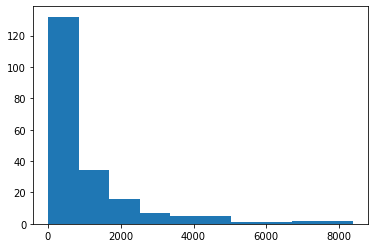

In [51]:
plt.hist([len(doc.get_content()) for doc in documents])

In [56]:
print(documents[-1].get_content())



Webinars with the CEO

When there's a webinar with the CEO, it is expected that the CEO Shadows execute the steps outlined in the `when the webinar is over` paragraph.




In [41]:
prompt = SEED_QUESTION.prompt.template.format(context=documents[5].get_content())

In [42]:
llm2(prompt)

<OpenAIObject chat.completion id=chatcmpl-8Irq2CbbWAQhdw5XiN4d4oAMeZTEm at 0x7fac8fce6700> JSON: {
  "id": "chatcmpl-8Irq2CbbWAQhdw5XiN4d4oAMeZTEm",
  "object": "chat.completion",
  "created": 1699507550,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "What are some myths about listening?"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 486,
    "completion_tokens": 7,
    "total_tokens": 493
  }
}